In [1]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.distributions.bernoulli import Bernoulli 
from torch.distributions.categorical import Categorical 
from torch.distributions.log_normal import LogNormal
from torch.distributions.normal import Normal

# For graphing purposes below
import matplotlib.pyplot as plt 
import seaborn as sns

# Internal packages
from data_loader import KidneyStoneDataset, ToTensor
from model import front_door_net, front_door_neg_loglik
from train import train

In [2]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS     = 150
LEARN_R    = 1e-3 #1e-3 #1e-2 # RMS
N_HU       = 32 #16
NLA = torch.tanh #torch.tanh #F.relu #torch.sigmoid 
#NLA = nn.LeakyReLU(1) # For a linear neural network

sd_idx = [0, 1, 2, 3] # Standarize the two continuous variables

# Initialize the dataset
data = KidneyStoneDataset("./data/front_door_data.npy", transform=ToTensor(), idx_sd=sd_idx)
#data = KidneyStoneDataset("./data/ks_non_linear_data_lp.npy", transform=ToTensor(), idx_mean=mean_idx, idx_sd=sd_idx)
train_loader = DataLoader(data, batch_size=BATCH_SIZE)

# Initialize the model
model = front_door_net(N_HU, NLA)

# Optimizers
#optimizer = optim.SGD(model.parameters(), lr=LEARN_R)
optimizer = optim.RMSprop(model.parameters(), lr=LEARN_R)

In [3]:
cum_loss = train(model, optimizer, front_door_neg_loglik, train_loader, EPOCHS)

In [5]:
# First, we get the parameters of the size variable:
n_samples = 50
arbitrary_query = torch.tensor([1., 1., 1., 1.]) # It is only important that the first element is 1

mu_X, log_sigma_X, _, _, _, _, _, _, _, _, _ = model(arbitrary_query.unsqueeze(0))
sigma_X = torch.exp(log_sigma_X)

X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

In [6]:
_, _, mu_Z, log_sigma_Z, _, _, mu_Z_X, log_sigma_Z_X, p_Z_X, _, _ = model(torch.tensor(data.ks_dataset).float())

# Samples from Z given X
sigma_Z = torch.exp(log_sigma_Z)
dist_Z  = Normal(mu_Z, sigma_Z)
samples_Z = dist_Z.sample()

# Mixture proportions
mixture_dist = Categorical(p_Z_X)
mixture = mixture_dist.sample()

# Mixture distributions
sigma_Z_X = torch.exp(log_sigma_Z_X)
normal = Normal(mu_Z_X, sigma_Z_X)
samples = normal.sample()

# Samples from the mixture distributions
Z_X_samples = samples[range(samples.shape[0]), mixture] # This uses samples
mu_Z_X_samples = mu_Z_X[range(mu_Z_X.shape[0]), mixture] # This uses the mean instead

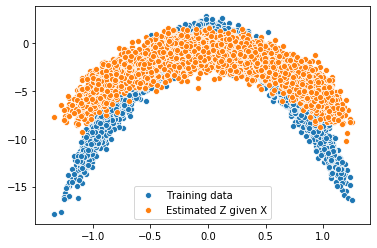

In [9]:
ax = sns.scatterplot(x=data.ks_dataset[:,0], y=data.ks_dataset[:,1], label="Training data") # Real data
ax = sns.scatterplot(x=data.ks_dataset[:,0], y=(samples_Z*data.sd[1]).detach().numpy()[:,0], label="Estimated Z given X")
#ax = sns.scatterplot(x=(Z_X_samples*data.sd[0]).detach().numpy(), y=data.ks_dataset[:,1], label="Estimated X given Z")

In [69]:
# Front door
# sum(z) P(Z=z | X=int_x) sum(x') P(Y|X=x', Z=z)P(X=x')
n_samples = 5000

intervention_query = torch.tensor([1., 1., 1., 1.]) # x == 1

# P(Z=z | X=int_x)
mu_X, log_sigma_X, mu_Z, log_sigma_Z, _, _, _, _, _, _, _ = model(intervention_query.unsqueeze(0))
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples = Z_dist.sample((n_samples,)).view(n_samples,1)

# P(X=x')
X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

# P(Y|X=x', Z=z)
# Pack the samples from the distributions:
ZX_samples = torch.cat([X_samples, Z_samples, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, _, _, _, mu_ZX_Y_1, _ = model(ZX_samples)

In [70]:
# Front door
# sum(z) P(Z=z | X=int_x) sum(x') P(Y|X=x', Z=z)P(X=x')
n_samples = 5000

intervention_query = torch.tensor([1., 0., 1., 1.]) # x == 1

# P(Z=z | X=int_x)
mu_X, log_sigma_X, mu_Z, log_sigma_Z, _, _, _, _, _, _, _ = model(intervention_query.unsqueeze(0))
sigma_Z = torch.exp(log_sigma_Z)

Z_dist = Normal(mu_Z, sigma_Z)
Z_samples = Z_dist.sample((n_samples,)).view(n_samples,1)

# P(X=x')
X_dist = Normal(mu_X, sigma_X)
X_samples = X_dist.sample((n_samples,)).view(n_samples,1)

# P(Y|X=x', Z=z)
# Pack the samples from the distributions:
ZX_samples = torch.cat([X_samples, Z_samples, torch.ones([n_samples, 2])], dim=1)
_, _, _, _, _, _, _, _, _, mu_ZX_Y_0, _ = model(ZX_samples)

In [71]:
torch.mean(mu_ZX_Y_1*data.sd[2])-torch.mean(mu_ZX_Y_0*data.sd[2])

tensor(0.0244, grad_fn=<SubBackward0>)

In [197]:
u = np.random.normal(size=(50, 1))
x = 1
z = np.random.normal(-10*x**2)
y_1 = np.random.normal(1/(np.exp(u)+np.exp(z)))

u = np.random.normal(size=(50, 1))
x = 0
z = np.random.normal(-10*x**2)
y_0 = np.random.normal(1/(np.exp(u)+np.exp(z)))

print(np.mean(y_1)-np.mean(y_0))

1.0756828525565456


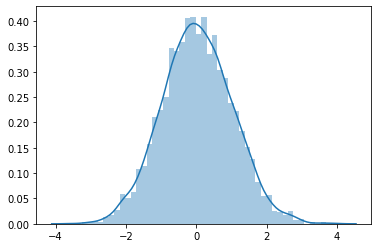

In [198]:
ax = sns.distplot(X_samples.detach().numpy())

In [202]:
u = np.random.normal(size=(5000, 1))
x = np.random.normal(np.sin(u), 0.1)

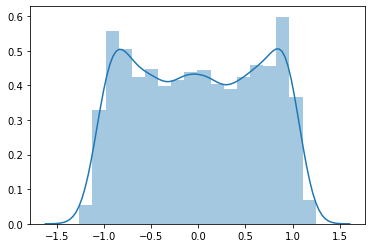

In [203]:
ax = sns.distplot(x)

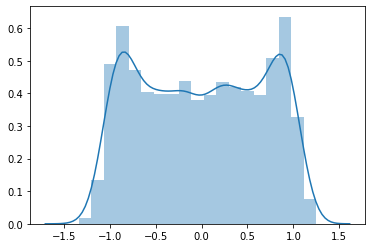

In [204]:
ax = sns.distplot(data.ks_dataset[:,0])